# Analysis of user behavior in a mobile application

Our startup sells food. We need to figure out how users of your mobile app behave. Let's study the sales funnel. Find out how users reach a purchase. Let's find out how many users reach the purchase, and how many get stuck on the previous steps and on which ones.

After that, we examine the results of the A/A/B experiment. Designers wanted to change fonts throughout the application, and managers were afraid that users would be unusual. We agreed to make a decision based on the results of the A/A/B test. Users were divided into 3 groups: 2 control groups with old fonts and one experimental group with new ones. Let's find out which font is better.


**Work Plan**

- **Step 1. Let's open the data files and study the general information**

    The path to the file:
    - /datasets/logs_exp.csv
        
        
- **Step 2. Prepare the data**
     
    - Replace the column names, if necessary;
    - Check gaps and data types;
    - Let's add a date and time column, as well as a separate date column.
    
    
- **Step 3. Examine and validate the data**

    - Find out how many events are in the log;
    - Find out how many users are in the log;
    - Find out how many events per user on average;
    - Determine the data for which period we have. Find the maximum and minimum date. Let's build a histogram by date and time. Let's find out if we can be sure that we have equally complete data for the entire period. Technically, in the logs of new days for some users, events from the past can “reach” - this can “skew the data”. Let's determine from what moment the data is complete and discard the older ones. Let's determine the data for which period of time we actually have;
    - Find out how many events and users we have lost by discarding the old data;
    - Let's check that we have users from all three experimental groups.
    
    
- **Step 4. Explore the funnel of events**

    - Let's see what events are in the logs, how often they occur. Sort events by frequency;
    - Let's count how many users made each of these events. Sort the events by the number of users. Let's calculate the share of users who have made an event at least once;
    - Consider the order in which events occur. Let's find out if they all line up in a sequential chain;
    - Based on the funnel of events, we calculate what proportion of users go to the next step of the funnel (from the number of users at the previous one). That is, for the sequence of events A → B → C, we calculate the ratio of the number of users with event B to the number of users with event A, as well as the ratio of the number of users with event C to the number of users with event B;
    - Find out at which step the most users are lost;
    - Determine what proportion of users reach the payment from the first event.
         
      
- **Step 5. Examine the results of the experiment**

    - Determine how many users are in each experimental group;
    - There are 2 control groups for the A/A experiment to check the correctness of all mechanisms and calculations. Let's check if the statistical tests find a difference between samples 246 and 247;
    - Choose the most popular event. Let's count the number of users who committed this event in each of the control groups. Let's calculate the share of users who made this event. Let's check whether the difference between the groups is statistically significant. Let's do the same for all other events (it's convenient to wrap the check in a separate function). Let's find out whether it is possible to say that the division into groups works correctly;
    - Let's do the same with the group with the changed font. Let's compare the results with each of the control groups separately for each event. Compare the results with the combined control group. Let us find out what conclusions can be drawn from the experiment;
    - Let's determine what level of significance we chose when testing the statistical hypotheses above. Let's count how many tests of statistical hypotheses we have done. At a significance level of 0.1, a false result can be obtained every tenth time. Determine what level of significance should be applied. Let's check the conclusions.
    

- **Step 6. Write a general conclusion**


- **Description of data**

   File `/datasets/logs_exp.csv` (user event log):

    - `EventName` — event name
    - `DeviceIDHash` - unique user ID
    - `EventTimestamp` — event time;
    - `ExpId` - the number of the experiment: 246 and 247 are the control groups, and 248 is the experimental group.

## Downloading data and exploring general information
Let's load the data into a variable and examine the general information.

The path to the file:
  - /datasets/logs_exp.csv.

In [1]:
# import required libraries
import pandas as pd 
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth

In [2]:
# reading a data file and saving to a variable
pth1 = '/datasets/logs_exp.csv'
pth2 = 'C:/Users/tatar/downloads/logs_exp.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, sep='\t')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, sep='\t')
else:
    print('Something is wrong')
    
# print the first 5 rows of the table
display(df.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# getting general information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# counting duplicate rows in a table
df.duplicated().sum()

413

**Conclusions**

* It is necessary to replace the column names, bring them to lower case and the correct style;
* It is necessary to cast the data in the column containing information about the date and time to the correct type;
* It is necessary to process duplicates;
* There are no missing values.

## Data preparation
Let's replace the column names, bring them to lowercase and the correct style.

In [5]:
# renaming columns
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 
                        'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'}) 

# check
df.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

We will process duplicates.

In [6]:
print('Percentage of duplicate rows in a dataframe:', round(df.duplicated().sum()/len(df['event_name']), 3))

Percentage of duplicate rows in a dataframe: 0.002


Since the proportion of duplicate rows in a dataframe is negligible, you can simply remove them.

In [7]:
# removing duplicates
df = (
    df
    .drop_duplicates()
    .reset_index(drop=True)
)

# check
df.duplicated().sum()

0

Let's deal with the dates. Let's add a column with the date and time of the event, the date of the event, and the month of the event.

In [8]:
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['event_date'] = df['event_datetime'].astype('datetime64[D]')
df['event_date'] = df['event_date'].dt.date
df['event_month'] = df['event_date'].astype('datetime64[M]')
df.head() 

,event_name,user_id,event_timestamp,exp_id,event_datetime,event_date,event_month
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,2019-07-01
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,2019-07-01
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-01
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-01
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,2019-07-01


**Conclusions**

So we did the following:
* Replaced the names of the columns, brought them to lower case and the correct type;
* Processed duplicates;
* Resulted in the correct type of data in columns containing date and time information. Added date and time columns, as well as a separate date column.

## Data validation
First, let's find out how many events are in the log.

In [9]:
print('Total events in the log:', df.shape[0])

Total events in the log: 243713


Find out how many users are in the log.

In [10]:
print('Total unique users in the log:', df['user_id'].nunique())

Total unique users in the log: 7551


Find out how many events per user on average.

In [11]:
# we will form an auxiliary table with information
# by number of events per user
events_by_users = (
    df
    .groupby('user_id')
    .agg({'event_name': 'count'})
    .rename(columns={'event_name':'number_of_events'})
    .reset_index()
)
print('Average number of events per user: {:.0f}'
      .format(events_by_users['number_of_events'].mean()))

Average number of events per user: 32


Now let's calculate the median number of events per user.

In [12]:
print('Median number of events per user: {:.0f}'.
      format(events_by_users['number_of_events'].median()))

Median number of events per user: 20


Let's look at the general information on the distribution of the number of events per user.

In [13]:
# output of general information about the distribution
# number of events per user
events_by_users['number_of_events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: number_of_events, dtype: float64

The maximum number of events per user is 2307, the standard deviation is 65.15. This suggests that we have data that is not normally distributed, there are outliers (users who perform an abnormally large number of actions). Let's calculate the 90th, 95th and 99th percentiles of the number of events per user.

In [14]:
print('90th, 95th and 99th percentile events per user:', 
      np.percentile(events_by_users['number_of_events'], [90, 95, 99])) 

90th, 95th and 99th percentile events per user: [ 64.   89.  200.5]


It is customary to filter out from 1% to 5% of observations with extreme values. Let's remove from the original dataframe users who have performed more than 90 actions (this is a little less than 5% of observations).

In [15]:
# cleaning the dataframe from anomalies
df_clean = df.loc[~(df['user_id'].isin(
    events_by_users.loc[events_by_users['number_of_events'] > 90,
                        'user_id']))]
df_clean.head()

,event_name,user_id,event_timestamp,exp_id,event_datetime,event_date,event_month
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,2019-07-01
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,2019-07-01
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-01
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-01
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,2019-07-01


Let's determine the data for which period we have.

In [16]:
print ('Minimum date:', df_clean['event_date'].min())
print ('Maximum date:', df_clean['event_date'].max())

Minimum date: 2019-07-25
Maximum date: 2019-08-07


As a result, we have data for two weeks. Let's build a histogram by date and time.

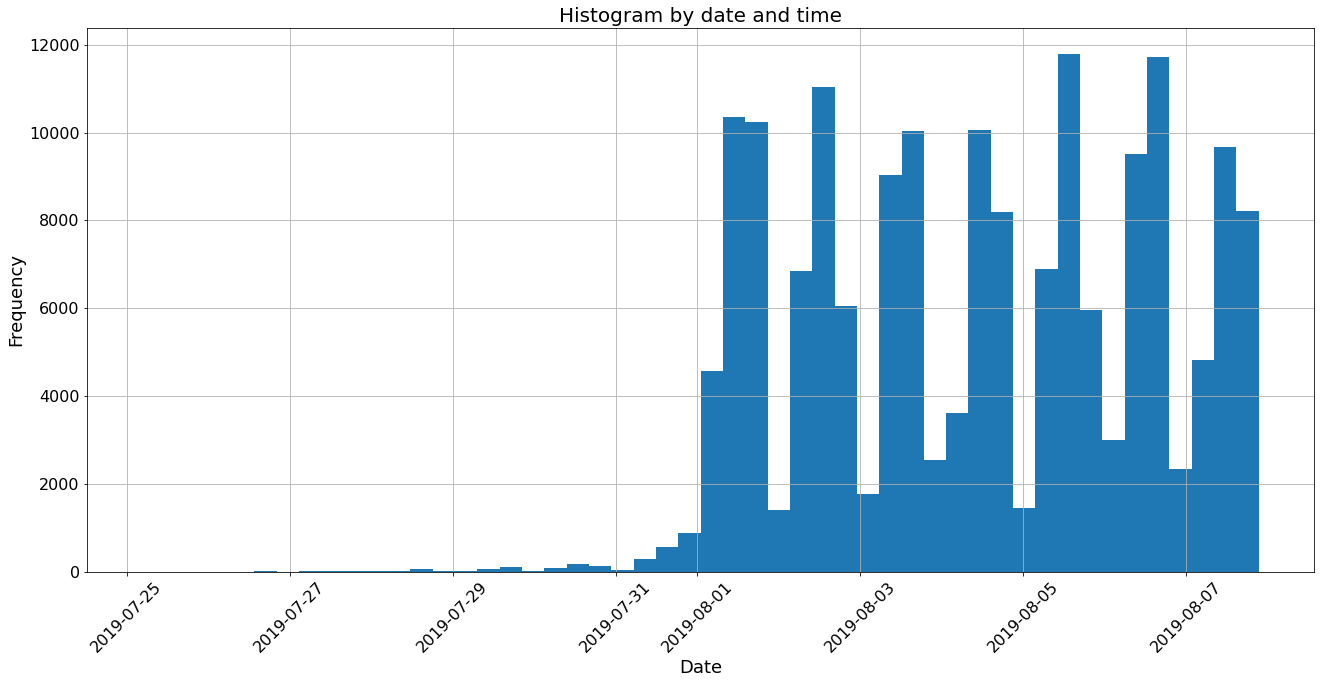

In [17]:
plt.figure(figsize=(22,10))
df_clean['event_datetime'].hist(bins=50)
plt.title('Histogram by date and time', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=16)
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=45)
plt.show()

According to the histogram, we have no data for the first week. In this regard, it would be more correct to "cut off" the data for July and use only the data for August only.

In [18]:
# formation of an auxiliary dataframe
# with data for August
df_filtered = df_clean.loc[df['event_month'] == '2019-08-01']

df_filtered.head()

,event_name,user_id,event_timestamp,exp_id,event_datetime,event_date,event_month
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2019-08-01


We previously determined that we have 243713 events in the log and 7551 unique users. Let's find out how many events and users we have lost by discarding the old data.

In [19]:
print('Total events in the log after "cleaning":', df_filtered.shape[0])
print('The number of unique users of the application after "cleaning":', df_filtered['user_id'].nunique())

Total events in the log after "cleaning": 171321
The number of unique users of the application after "cleaning": 7173


In [20]:
print('Losses in the number of events after "cleaning":', df_clean.shape[0] - df_filtered.shape[0])
print('Losses in the number of unique users of the application after "cleaning":', 
      df_clean['user_id'].nunique() - df_filtered['user_id'].nunique())

Losses in the number of events after "cleaning": 2410
Losses in the number of unique users of the application after "cleaning": 17


Losses in the number of events and unique users in the dataframe after the "cleaning" are negligible, they can be considered insignificant.

Let's check that we have users from all three experimental groups.

In [21]:
# displaying the number of users
# by test groups
(
    df_clean
    .groupby('exp_id')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id':'number_of_users'})
)

,number_of_users
exp_id,
246,2370
247,2406
248,2414


**Conclusions**

The sample was slightly shortened, leaving only the data for the first week of August 2019 for analysis. There are users from all three testing groups. The data has been studied, verified and cleaned of anomalies. Now we can start the analysis.

## Event funnel analysis
Let's start studying the funnel of events and start by getting to know the events themselves. Let's see what events are in the logs, how often they occur. Sort events by frequency.

In [22]:
# formation of a pivot table
events_count = (
    df_filtered
    .pivot_table(index='event_name', values='user_id', aggfunc='count')
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'number_of_events'})
)
events_count

,number_of_events
event_name,
MainScreenAppear,99416
OffersScreenAppear,32187
CartScreenAppear,22124
PaymentScreenSuccessful,16667
Tutorial,927


The log contains five different variants of events:

    * `MainScreenAppear` - the appearance of the main screen;
    * `OffersScreenAppear` - the appearance of a screen with products;
    * `CartScreenAppear` - the appearance of the screen with the basket;
    * `PaymentScreenSuccessful` - appearance of the payment confirmation screen;
    * `Tutorial` - appearance of the tutorial screen.
   
Let's count how many users made each of these events.

In [23]:
# auxiliary table formation
number_of_events_by_users = (
    df_filtered
    .groupby('user_id')['event_name']
    .nunique()
    .reset_index()
)
print('The number of users who completed each of the events:',
      number_of_events_by_users[number_of_events_by_users['event_name'] > 4]['user_id']
      .count())

The number of users who completed each of the events: 406


Sort events by number of users.

In [24]:
# auxiliary table formation
funnel = (
    df_filtered
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'user_id': 'number_of_users'})
)
funnel

,event_name,number_of_users
0,MainScreenAppear,7063
1,OffersScreenAppear,4245
2,CartScreenAppear,3397
3,PaymentScreenSuccessful,3205
4,Tutorial,776


Let's calculate the share of users who have made an event at least once.

In [25]:
print('Percentage of users who completed only one event:', 
      round(number_of_events_by_users[number_of_events_by_users['event_name'] == 1]['user_id']
      .count() / df_filtered['user_id'].nunique(), 2))

Percentage of users who completed only one event: 0.38


Let's try to figure out in what order the events occur. Let's try to do this using the example of our users with one event. Let's see what the only event they had.

In [26]:
# displaying a list of events for users,
# who made one event
df_filtered.loc[df_filtered['user_id'].
                isin(number_of_events_by_users[number_of_events_by_users['event_name'] == 1]['user_id']),
                'event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'Tutorial'], dtype=object)

You can see that in addition to `MainScreenAppear`, the first events can be `OffersScreenAppear` and `Tutorial`. If with `Tutorial` it can be assumed that there is an opportunity to get trained at the very beginning of using the application, then with `OffersScreenAppear` everything is not so clear. Let's test the hypothesis that the appearance of the screen with products as the first event is due to the fact that we are logs from an earlier period (the ones that we "cut off" earlier).

In [27]:
# outputting the number of times 'OffersScreenAppear'
# is the first event
len(
    df_filtered
    .loc[(df_filtered['user_id']
          .isin(number_of_events_by_users[number_of_events_by_users['event_name'] == 1]['user_id'])) 
         & (df_filtered['event_name'] == 'OffersScreenAppear')])

31

There are 31 entries in the log, so they can be neglected. And this indirectly confirms the hypothesis about the connection with the logs from an earlier period (data for July). Events in most cases occur according to the following scenario:

   * `MainScreenAppear` - the appearance of the main screen, the user enters the application;
   * `OffersScreenAppear` - the appearance of a screen with products, the user gets acquainted with the products, makes a choice;
   * `CartScreenAppear` - the appearance of the screen with the cart, the user adds products to the cart;
   * `PaymentScreenSuccessful` - the appearance of a payment confirmation screen, the user pays for the purchase.
   
`Tutorial` - the appearance of the tutorial screen is most likely optional, depending on the user's desire. He can either just watch the training without performing additional actions, or go to training at any stage of using the application. Once again, we will build a funnel, without taking into account "learning" and calculate the proportion of those who have moved to the next step.

In [28]:
# auxiliary table formation
funnel_w_o_tutorial = (
    df_filtered
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'user_id': 'number_of_users'})
    .drop(4)
)
funnel_w_o_tutorial['ratio'] = round(funnel_w_o_tutorial['number_of_users'] / 
                                     funnel_w_o_tutorial['number_of_users']
                                     .shift(periods=1, fill_value=1*7063), 2)
funnel_w_o_tutorial

,event_name,number_of_users,ratio
0,MainScreenAppear,7063,1.00
1,OffersScreenAppear,4245,0.60
2,CartScreenAppear,3397,0.80
3,PaymentScreenSuccessful,3205,0.94


The results show that about 40% of users did not go beyond the first step. Let's calculate the percentage of users who made it from the first step to a successful purchase.

In [29]:
print('Percentage of users who made it from the first step to a successful purchase:',
      round((funnel_w_o_tutorial.iloc[3,1] / funnel_w_o_tutorial.iloc[0,1]) * 100, 2), '%')

Percentage of users who made it from the first step to a successful purchase: 45.38 %


**Conclusions**

Thus, we found out the following:
* A total of 406 users completed all five events.;
* After compiling the funnel, we found that after the first step, about 40% of users “fall off”, after subsequent steps, the loss is much less;
* Putting the product in the shopping cart, the user will almost certainly make a purchase.

## Analysis of the results of the experiment
Let's start studying the results of the experiment. First, let's determine how many users are in each experimental group.

In [30]:
# displaying the number of users
# by test groups
number_of_users_filtered = (
    df_filtered
    .groupby('exp_id')
    .agg({'user_id': 'nunique'})
    .reset_index()
    .rename(columns={'user_id':'number_of_users'})
)
number_of_users_filtered

,exp_id,number_of_users
0,246,2365
1,247,2399
2,248,2409


Let's check if the statistical criteria find the difference between samples 246 and 247. To do this, we will form a table with information on events for each group.

In [31]:
# auxiliary table formation
users_by_events = (
    df_filtered
    .pivot_table(index = 'exp_id',
                 columns = 'event_name',
                 values = 'user_id',
                 aggfunc = 'nunique')
    .reset_index()
)

# add a column with quantity
# users in groups
users_by_events['number_of_users'] = number_of_users_filtered['number_of_users']

users_by_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,number_of_users
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409


Let's compare the shares of customers of groups 246 and 247 who paid for the order. Out of 2365 users of the 246 group, 1088 people paid for the order; and out of 2399 users of the group 247 - 1055. Let's try to draw a conclusion about the difference in conversion for these groups. First, let's formulate hypotheses:

    * H₀ - there are no differences in the shares of customers who paid for the order between groups;
    * H₁ - there are differences in the shares of customers who paid for the order between groups.
   
Let's create a function.

In [32]:
# auxiliary function formation
# to display test results
def result(value_1, value_2):
    if value_1 < value_2:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

# function formation
def hypo_test (trials_1, trials_2, successes_1, successes_2, alpha):
    
    # proportion of successes in the first group
    p1 = successes_1/trials_1
    
    # proportion of successes in the second group
    p2 = successes_2/trials_2

    # proportion of successes in the combined dataset
    p_combined = (successes_1 + 
                  successes_2) / (trials_1 + 
                                 trials_2)

    # difference in proportions in datasets
    difference = p1 - p2 

    # we consider statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * 
                                    (1 - p_combined) * 
                                    (1 / trials_1 + 1 / trials_2))

    # set the standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    pr_1 = print('p-value: ', p_value)
    
    pr_2 = result(p_value, alpha)
    
    return pr_1, pr_2

Let's test the hypotheses by running the function for groups 246 and 247 and assigning a critical level of statistical significance equal to 0.05.

In [33]:
print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events.columns[4], 'in groups 246 and 247**')
hypo_test (users_by_events.iloc[0,6],
           users_by_events.iloc[1,6],
           users_by_events.iloc[0,4],
           users_by_events.iloc[1,4], 0.05)

**Hypothesis testing about differences in customer shares by event PaymentScreenSuccessful in groups 246 and 247**
p-value:  0.15956763723683043
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


(None, None)

The test was carried out correctly - no statistically significant differences were found between the two A-groups.

Let's choose the most popular event. Judging by the `users_by_events` table, the most popular event is expected to be `MainScreenAppear` - the appearance of the main screen. We determined the number of users in the groups that committed this event, it remains to calculate the shares of the total number of users by groups. For convenience, we will form an auxiliary table and display it on the screen.

In [34]:
# auxiliary table formation
top_event = users_by_events[['exp_id', 'MainScreenAppear', 'number_of_users']].copy()
top_event['ratio'] = round(top_event['MainScreenAppear'] / top_event['number_of_users'], 3)
top_event

event_name,exp_id,MainScreenAppear,number_of_users,ratio
0,246,2332,2365,0.986
1,247,2365,2399,0.986
2,248,2366,2409,0.982


The vast majority of users in each of the groups (98-99%) went through the main screen of the application.

Let's check whether the difference between groups 246 and 247 is statistically significant.

In [35]:
print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events.columns[2], 'in groups 246 and 247**')
hypo_test (users_by_events.iloc[0,6], 
           users_by_events.iloc[1,6], 
           users_by_events.iloc[0,2], 
           users_by_events.iloc[1,2], 0.05)

**Hypothesis testing about differences in customer shares by event MainScreenAppear in groups 246 and 247**
p-value:  0.9488058453077359
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


(None, None)

There were no statistically significant differences between groups 246 and 247 in the results of checking differences in the proportion of customers interacting with the main screen.

Let's check the rest of the events. Let's go in order: `OffersScreenAppear`, `CartScreenAppear` and `Tutorial`.

In [36]:
# use the cycle
column_list = [3, 1, 5]
for column_number in column_list:
    print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events.columns[column_number], 'in groups 246 and 247**')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[1,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[1,column_number], 0.05)
    print('\n')

**Hypothesis testing about differences in customer shares by event OffersScreenAppear in groups 246 and 247**
p-value:  0.2844644518221826
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event CartScreenAppear in groups 246 and 247**
p-value:  0.2920961972474885
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event Tutorial in groups 246 and 247**
p-value:  0.6004592136258189
It was not possible to reject the null hypothesis, there is no reason to consider the shares different




Based on the results of the checks, it can be concluded that there are no statistically significant differences between groups 246 and 247 and the groups are divided correctly.

Let's compare the results of group 248 with each of groups 246 and 247 separately for each event.

In [37]:
# use the cycle
column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events.columns[column_number], 'in groups 246 and 248**')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events.columns[column_number], 'in groups 247 and 248**')
    hypo_test (users_by_events.iloc[1,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[1,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('\n')

**Hypothesis testing about differences in customer shares by event MainScreenAppear in groups 246 and 248**
p-value:  0.2822092595945087
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event MainScreenAppear in groups 247 and 248**
p-value:  0.30983823318398684
It was not possible to reject the null hypothesis, there is no reason to consider the shares different




**Hypothesis testing about differences in customer shares by event OffersScreenAppear in groups 246 and 248**
p-value:  0.17411984437962635
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event OffersScreenAppear in groups 247 and 248**
p-value:  0.7727788233190573
It was not possible to reject the null hypothesis, there is no reason to consider the shares different




**Hypothesis testing a

Based on the results of the checks, it can be generally concluded that there are no statistically significant differences between groups 246, 247 and 248. Preliminarily, we can conclude that the font replacement did not affect users.

Next, add a row to the `users_by_events` table with data on the combined control group 246_247 to compare the results with group 248.

In [38]:
# supplementing the table with information on the combined control group
new_row = users_by_events.loc[0] + users_by_events.loc[1]
users_by_events_all = users_by_events.copy()
users_by_events_all = users_by_events_all.append([new_row]).reset_index(drop=True)
users_by_events_all.iloc[3,0] = '246_247'
users_by_events_all

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,number_of_users
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409
3,246_247,2288,4697,2838,2143,521,4764


Let's compare the results of group 248 with the combined control group 246_247 separately for each event.

In [39]:
# use the cycle
column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('**Hypothesis testing about differences in customer shares by event', 
      users_by_events_all.columns[column_number], 'in groups 246_247 and 248**')
    hypo_test (users_by_events_all.iloc[3,6],
               users_by_events_all.iloc[2,6],
               users_by_events_all.iloc[3,column_number],
               users_by_events_all.iloc[2,column_number], 0.05)
    print('\n')

**Hypothesis testing about differences in customer shares by event MainScreenAppear in groups 246_247 and 248**
p-value:  0.2178174063864624
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event OffersScreenAppear in groups 246_247 and 248**
p-value:  0.342740437463807
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event CartScreenAppear in groups 246_247 and 248**
p-value:  0.11068078406757342
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypothesis testing about differences in customer shares by event PaymentScreenSuccessful in groups 246_247 and 248**
p-value:  0.46973441160530083
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


**Hypo

Based on the results of the checks, it can be concluded that there are no statistically significant differences between groups 246_247 and 248 either.
Let us confirm the conclusion that the font change did not affect users.

When testing the statistical hypotheses above, we chose a significance level of 0.05. Let's count how many tests of statistical hypotheses we have done. We conducted a multiple test, i.e. multiple samples were taken from the same dataset. Its peculiarity is that with each new test of the hypothesis, the probability of a type I error increases. At a significance level of 0.1, a false result can be obtained every tenth time.

In [40]:
number_of_test = len(users_by_events_all['exp_id'].unique()) * len(df['event_name'].unique())
print('Statistical hypotheses were tested:', number_of_test, 'times')

Statistical hypotheses were tested: 20 times


Determine what level of significance should be applied. We choose the Shidak method - it is the most accurate. Calculate the `p-value`.

In [41]:
p_value = 1 - (1 - 0.05)**(1 / number_of_test)
print('Refined p-value:', p_value)

Refined p-value: 0.0025613787765302876


The results won't change, the adjusted p-value is even smaller. The changes we made did not affect the metrics and user behavior in any way. Therefore, there is no point in applying them to the entire resource - they will not bring any benefit to the business.

## General conclusion

Ultimately, 20 statistical hypothesis tests were performed. The results showed that there were no statistically significant differences between groups 246, 247, and 248, and there were also no differences between groups 246_247 and 248. A significance level of 0.05 was used, which in our case does not make much sense, since the value refined by the Shidak method turned out to be still less.

Based on the data obtained, it can be argued that the hypothesis that changing the font on the main page will somehow affect the conversion metrics was not confirmed. However, given that we only have 1 week of data, it is recommended to collect 1 more week of data (to have a 2 week picture) and recalculate. But it is not worth expecting that the situation will change dramatically and we will find statistically significant differences between the groups, given the p_values obtained.